In [1]:
import argparse
import numpy as np
import os
import tabulate
import torch
import torch.nn.functional as F
import torch.nn

import data
import models
import curves
import utils

import pickle

In [2]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from scipy.stats import norm

import utils
import time
from torch import nn
import seaborn as sns
from sklearn.manifold import TSNE
from pylab import rcParams

In [3]:
loaders, num_classes = data.loaders(
    "MNIST",
    "data",
    128,
    1,
    "VGG",
    True)

You are going to run models on the test set. Are you sure?


In [4]:
architecture = getattr(models, "LinearOneLayer") #LinearOneLayer LogRegression
model1 = architecture.base(num_classes=10, **architecture.kwargs)
model2 = architecture.base(num_classes=10, **architecture.kwargs)
m = architecture.base(num_classes=10, **architecture.kwargs)

model1.load_state_dict(torch.load('curves_mnist/LinearOneLayer/LongTraining/curve3/checkpoint-30.pt')['model_state'])
model2.load_state_dict(torch.load('curves_mnist/LinearOneLayer/LongTraining/curve4/checkpoint-30.pt')['model_state'])

In [5]:
def distance(model1, model2):
    par1 = np.concatenate([p.data.cpu().numpy().ravel() for p in model1.parameters()])
    par2 = np.concatenate([p.data.cpu().numpy().ravel() for p in model2.parameters()])
    u = par2 - par1
    dx = np.linalg.norm(u)
    return dx

In [6]:
def get_vector(model1):
    par1 = np.concatenate([p.data.cpu().numpy().ravel() for p in model1.parameters()])
    return par1

In [7]:
def samples(model):
    p1 = list(model.parameters())[0].data.cpu().numpy()
    p2 = list(model.parameters())[1].data.cpu().numpy()
    p3 = list(model.parameters())[2].transpose(0,1).data.cpu().numpy()
    samples = np.hstack([p1, p2[:, None], p3])
    
    return samples

## Making dataset 

In [8]:
ind = 1
T = True
S = []
B = []
while ind<20:

    ckpt = 'curves_mnist/LinearOneLayer/LongTraining/curve'+str(ind)+'/checkpoint-30.pt'
    checkpoint = torch.load(ckpt)
    m.load_state_dict(checkpoint['model_state'])
    
    S.append(samples(m))
    B.append(list(m.parameters())[-1].data.numpy())
    ind+=1
    
S = np.concatenate(S)

In [9]:
# len(S)/512

In [28]:
from torch.optim.lr_scheduler import StepLR

def train(flow, model1, model2, epochs=20, lr=1e-5, batchsize=512, step=10, test_every=20, start_epoch=1):
    flow.cuda();
    flow.train();
    trainable_parametrs = filter(lambda param: param.requires_grad, flow.parameters()) # list of all trainable parameters in a flow
    optimizer = torch.optim.Adam(trainable_parametrs, lr=lr, weight_decay=1e-4)# choose an optimizer, use module torch.optim
    scheduler = StepLR(optimizer, step_size=20, gamma=0.9)# decrease learning rate by torch.optim.lr_scheduler

    for epoch in range(start_epoch, epochs+1):  
        scheduler.step()
        flow.train()
        
        t = time.time()
        total_loss = 0

        for X in iterate_minibatches(S, batchsize):

            loss = -flow.log_prob(X).mean() #  compute the maximum-likelihood loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss+=loss
        
        total_loss /=(len(S)//batchsize)
        if epoch % step == 0:
            print('epoch %s:' % epoch, 'loss = %.3f' % total_loss, 'time = %.2f' %  (time.time()-t))
        if epoch % test_every == 0:
            test_flow(S, model1, model2, flow, N=2000)
        if epoch % 50 ==0:
            utils.save_checkpoint(
                'flows_checkpoints/RNVPjn',
                epoch,
                model_state=flow.state_dict(),
                optimizer_state=None
            )


In [11]:
# os.makedirs('flows_checkpoints/RNVPjn', exist_ok=True)

## Generator 

In [12]:
def iterate_minibatches(train_data, batchsize):
    indices = np.random.permutation(np.arange(len(train_data)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield torch.FloatTensor(train_data[ix]).cuda()

In [13]:
from torch import distributions
prior = distributions.MultivariateNormal(torch.zeros(795), torch.eye(795))

In [14]:
N = 2
X = torch.FloatTensor(S[:N]).cuda()

In [15]:
# X.shape

In [16]:
def get_model(W, B):
    model_sampled = architecture.base(num_classes=10, **architecture.kwargs)
    model_samples = W.cpu().data.numpy()
    SIZE = 2000

    offset = 0
    for parameter in list(model_sampled.parameters())[:-1]:
        size = int(np.prod(parameter.size())/SIZE)
        value = model_samples[:, offset:offset+size]
        if size==10 or size==1:
             value = value.T
#         print(value.shape)
        value = value.reshape(parameter.size())
#         print(value.shape)
        parameter.data.copy_(torch.from_numpy(value))
        offset += size

    list(model_sampled.parameters())[-1].data.copy_(torch.from_numpy(B.mean(0)))
    
    return model_sampled

def test(model):
    criterion = F.cross_entropy
    regularizer = None 
    train_res = utils.test(loaders['train'], model, criterion, regularizer)
    test_res = utils.test(loaders['test'], model, criterion, regularizer) 
    print(train_res)
    print(test_res)

def test_flow(S, model1, model2, flow, N=2000):
    
    rcParams['figure.figsize'] = 12, 10
    rcParams['figure.dpi'] = 100

    flow.cuda()
    flow.eval()
    print('copmuting samples...')
    X = torch.FloatTensor(S[:N]).cuda()
    X_sample = X.data.cpu().numpy()
    X_prior = prior.sample((N,)).cpu().data.numpy()
    X_flow = flow.sample(N, ).data.cpu().numpy()
    X_sample_prior = flow.f(torch.FloatTensor(X_sample).cuda())[0].data.cpu().numpy()
    
    print('drawing...')
    i, j = 500, -1
    fig, axes = plt.subplots(2, 2,)
    axes[0, 0].set_title('Samples')
    axes[0, 0].scatter(X_sample[:, i], X_sample[:, j])
    axes[0, 1].set_title('Prior')
    axes[0, 1].scatter(X_prior[:, i], X_prior[:, j])
    axes[1, 0].set_title('Flow sampling')
    axes[1, 0].scatter(X_flow[:, i], X_flow[:, j])
    axes[1, 1].set_title('Map from samples to prior')
    axes[1, 1].scatter(X_sample_prior[:, i], X_sample_prior[:, j]) 
    plt.show()
    
    print('computing Arc model...')
    W1 = samples(model1)
    W2 = samples(model2)
    
#     flow.cpu()
    W_pre = 1/np.sqrt(2)*flow.f(torch.FloatTensor(W1).cuda())[0]+1/np.sqrt(2)*flow.f(torch.FloatTensor(W2).cuda())[0]
    W = flow.g(W_pre)
    B = []
    B.append(list(model1.parameters())[-1].data.cpu().numpy())
    B.append(list(model2.parameters())[-1].data.cpu().numpy())
    B = np.array(B)
    
    model_sampled = get_model(W, B)
    test(model_sampled)
    
    if N==2000:
        B = []
        B.append(flow.b2.data.cpu().numpy())
        B = np.array(B)
        print('computing Sampling from flow model...')
        X_flow = flow.sample(N, ).data.cpu()
        
        model_flow = get_model(X_flow, B)
        test(model_flow)
#         return model_sampled, model_flow
    
#     return model_sampled
    

In [17]:
class BatchNorm(nn.Module):
    def __init__(self, dim_in):
        super(BatchNorm, self).__init__()

        self.mu = torch.zeros(dim_in).cuda()
        self.sig2 = torch.zeros(dim_in).cuda()+0.1
        self.momentum=0.1
        
    def forward(self, x):

        if self.training:
            mu = x.mean(0)
            sig2 = (x-mu).pow(2).mean(0)  
            x = (x-mu)/(sig2 + 1.0e-6 ).sqrt()
            self.mu = self.momentum*mu + (1-self.momentum)*self.mu
            self.sig2 =  self.momentum*sig2 + (1-self.momentum)*self.sig2
            return x, sig2+1.0e-6 
        else: 
            x = (x-self.mu)/(self.sig2+1.0e-6).sqrt()
            return x, self.sig2+1.0e-6 

## Flow Generator 

In [18]:
# class SNet(nn.Module):
#     def __init__(self, dim_in, dim_middle):
#         super(SNet, self).__init__()
#         self.fc = nn.Sequential(
#             nn.Linear(dim_in, dim_middle),
#             nn.LeakyReLU(),
#             nn.Linear(dim_middle, dim_middle),
#             nn.LeakyReLU(),
#             nn.Linear(dim_middle, dim_in)
#         )
        
#     def forward(self, x):   
#         x = self.fc(x)
#         return x
    
# class TNet(nn.Module):
#     def __init__(self, dim_in, dim_middle):
#         super(TNet, self).__init__()
#         self.fc = nn.Sequential(
#             nn.Linear(dim_in, dim_middle),
#             nn.LeakyReLU(),
#             nn.Linear(dim_middle, dim_middle),
#             nn.LeakyReLU(),
#             nn.Linear(dim_middle, dim_in),
#         )
        
#     def forward(self, x):   
#         x = self.fc(x)
#         return x
    
# # class SNetF(nn.Module):
# #     def __init__(self, dim_in, dim_middle):
# #         super(SNetF, self).__init__()
# #         self.fc = nn.Sequential(
# #             nn.Linear(dim_in, dim_middle),
# #             nn.LeakyReLU(),
# #             nn.Linear(dim_middle, dim_middle),
# #             nn.LeakyReLU(),
# #             nn.Linear(dim_middle, dim_in)
# #         )
        
# #     def forward(self, x):   
# #         x = self.fc(x)
# #         return x
    
# # class TNetF(nn.Module):
# #     def __init__(self, dim_in, dim_middle):
# #         super(TNetF, self).__init__()
# #         self.fc = nn.Sequential(
# #             nn.Linear(dim_in, dim_middle),
# #             nn.LeakyReLU(),
# #             nn.Linear(dim_middle, dim_middle),
# #             nn.LeakyReLU(),
# #             nn.Linear(dim_middle, dim_in),
# #         )
        
# #     def forward(self, x):   
# #         x = self.fc(x)
# #         return x
    
    

In [19]:
class SNet(nn.Module):
    def __init__(self, dim_in, dim_middle):
        super(SNet, self).__init__()
        affine = True
        self.h = nn.Tanh() #nn.LeakyReLU() #nn.Tanh()
        self.fc = nn.Sequential(
            nn.Linear(dim_in, dim_middle),
            self.h,
            nn.BatchNorm1d(dim_middle, affine=affine),
            nn.Linear(dim_middle, dim_middle),
            self.h,
            nn.BatchNorm1d(dim_middle, affine=affine),
            nn.Linear(dim_middle, dim_in)
        )
        
    def forward(self, x):   
        x = self.fc(x)
#         x = torch.clamp(x, -1, 1) 
        return x
    
class TNet(nn.Module):
    def __init__(self,  dim_in, dim_middle):
        super(TNet, self).__init__()
        affine = True
        self.h = nn.Tanh()
        self.fc = nn.Sequential(
            nn.Linear(dim_in, dim_middle),
            self.h,
            nn.BatchNorm1d(dim_middle, affine=affine),
            nn.Linear(dim_middle, dim_middle),
            self.h,
            nn.BatchNorm1d(dim_middle, affine=affine),
            nn.Linear(dim_middle, dim_in),
        )
        
    def forward(self, x):   
        x = self.fc(x)
        return x


In [20]:
import numpy as np
N_layers = 7
n_dim = 795
onezero = [0, 1]*n_dim
masks = torch.Tensor([[onezero[:n_dim], onezero[1:n_dim+1]]]*N_layers)
masks = masks.view(2*N_layers, -1)
len(masks)

14

In [21]:
class RealNVP(nn.Module):
    def __init__(self, mask, prior):
        super(RealNVP, self).__init__()
        
        # Create a flow
        # nets:  a function that return a pytocrn neurel network e.g., nn.Sequential, s = nets(), s: dim(X) -> dim(X)
        # nett:  a function that return a pytocrn neurel network e.g., nn.Sequential, t = nett(), t: dim(X) -> dim(X)
        # mask:  a torch.Tensor of size #number_of_coupling_layers x #dim(X)
        # prior: an object from torch.distributions e.g., torch.distributions.MultivariateNormal
        
        self.prior = prior 
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([SNet(dim_in=795, dim_middle=795*2) for _ in range(len(mask))])
        self.s = torch.nn.ModuleList([TNet(dim_in=795, dim_middle=795*2) for _ in range(len(mask))])
        self.b = torch.nn.ModuleList([BatchNorm(dim_in=795) for _ in range(len(mask))])
        self.batch_norm = True
        self.verbose = False
        
        # for prediction
        self.relu = nn.ReLU()
        data_b2 = torch.FloatTensor(np.random.normal(size=(10, ))).cuda()
        self.b2 = nn.Parameter(data = data_b2, requires_grad=True)
        
    def g(self, z):
        # Compute and return g(z) = x, 
        #    where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer   
        # z: a torch.Tensor of shape batchSize x 1 x dim(X)
        # return x: a torch.Tensor of shape batchSize x 1 x dim(X)
        for i, (s, t, b) in enumerate(zip(reversed(self.s), reversed(self.t), reversed(self.b))):
            m = self.mask[-i-1]
#             print('i', i, 'm', m)
            
            if self.verbose:
                print('z1', z)
            z = (m*z +(1-m)*(z-t(m*z))*(-s(m*z)).exp()).detach()
#             print('z1', z)
            if self.batch_norm:
                z = (z*(b.sig2+1.0e-6).sqrt()+b.mu).detach()
            if self.verbose:
                print('z2', z)
        
        x = z
        return x

    def f(self, x):
        # Compute f(x) = z and log_det_Jakobian of f, 
        #    where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer   
        # x: a torch.Tensor, of shape batchSize x dim(X), is a datapoint
        # return z: a torch.Tensor of shape batchSize x dim(X), a hidden representations
        # return log_det_J: a torch.Tensor of len batchSize
        
        z = x
        log_det_J = 0
        for s, t, m, b in zip(self.s, self.t, self.mask, self.b):

            if self.batch_norm:
                z, sig2 = b(z)
#             print(m.shape, z.shape)
            s_res = s(m*z)
            z = m*z +(1-m)*(z*s_res.exp()+t(m*z))
           
            if self.batch_norm:
                log_det_J += ((1-m)*s_res-0.5*sig2.log()).sum(-1)
            else:
                log_det_J += ((1-m)*s_res).sum(-1)
        
        return z, log_det_J
    
    def log_prob(self,x):
        # Compute and return log p(x)
        # using the change of variable formula and log_det_J computed by f
        # return logp: torch.Tensor of len batchSize
        z, log_det_J = self.f(x)
        
        logp = -0.5*np.log(np.pi*2)-0.5*z.pow(2)
        logp = logp.sum(-1)
#         logp = self.prior.log_prob(z)
#         logp = self.prior.log_prob(z.cpu()).cuda()
#         shape = torch.Size((K, self.in_dim))
#         logp = torch.cuda.FloatTensor(x.shape[0])
#         self.prior.log_prob(z.cpu(), out=logp)
        
#         logp = self.prior.log_prob(z.cpu()).cuda()
#         print('logp', logp.shape)
        
        return logp+log_det_J
        
    def sample(self, K): 
        # Draw and return batchSize samples from flow using implementation of g
        # return x: torch.Tensor of shape batchSize x 1 x dim(X)
        shape = torch.Size((K, 795))
        e = torch.cuda.FloatTensor(shape)
        torch.randn(shape, out=e)   
        x = self.g(e)
        
#         z = self.prior.sample((K, )).cuda()
#         x = self.g(z)
        
        return x
    
    def forward(self, x, K=2000):
        
        x = x.view(x.size(0), -1)
        W = self.sample(K)
        W1 = W[:, :784]
        b1 = W[:, 784:785]
        W2 =  W[:, 785:].transpose(0,1)
        
        if self.verbose:
            print('x', x.shape)
            print('W1', W1.shape)
            print('b1', b1.shape)
            
        x = F.linear(x, W1, b1[:, 0])
        
        if self.verbose:
            print('x', x.shape)
            print(x.shape)
            
        x = self.relu(x)

        x = F.linear(x, W2, self.b2) 
#         x = 1/K*x
        
        if self.verbose:
            print(x.shape)
            
        return x
        

In [22]:
def train(flow, model1, model2, epochs=20, lr=1e-5, batchsize=512, step=10, test_every=20, start_epoch=1):
    flow.cuda();
    flow.train();
    trainable_parametrs = filter(lambda param: param.requires_grad, flow.parameters()) # list of all trainable parameters in a flow
    optimizer = torch.optim.Adam(trainable_parametrs, lr=lr, weight_decay=0)# choose an optimizer, use module torch.optim
    scheduler = StepLR(optimizer, step_size=20, gamma=0.9)# decrease learning rate by torch.optim.lr_scheduler
    regularizer = None
    criterion = F.cross_entropy
    
    trainable_parametrs = filter(lambda param: param.requires_grad, flow.parameters())
    optimizer2 = torch.optim.Adam(trainable_parametrs, lr=1e-3, weight_decay=0)# choos
    
    columns = ['ep', 'tr_loss', 'tr_acc', 'te_nll', 'te_acc', 'time']
    
    for epoch in range(start_epoch, epochs+1):  
        scheduler.step()
        flow.train()
        
        t = time.time()
        total_loss = 0

        for X in iterate_minibatches(S, batchsize):

            loss = -flow.log_prob(X).mean() #  compute the maximum-likelihood loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss+=loss
        
        total_loss /=(len(S)//batchsize)
        if epoch % step == 0:
            print('epoch %s:' % epoch, 'loss = %.3f' % total_loss, 'time = %.2f' %  (time.time()-t))
        if epoch % 50 ==0:
            utils.save_checkpoint(
                'flows_checkpoints/RNVPjn',
                epoch,
                model_state=flow.state_dict(),
                optimizer_state=None
            )
        if epoch % 10 == 0:
            time_ep = time.time()
            train_res = utils.train(loaders['train'], flow, optimizer2, criterion, regularizer, cuda=True)
            test_res = utils.test(loaders['test'], flow, criterion, regularizer, cuda=True)
            time_ep = time.time() - time_ep
            values = [epoch, train_res['loss'], train_res['accuracy'], test_res['nll'],
                      test_res['accuracy'], time_ep]

            table = tabulate.tabulate([values], columns, tablefmt='simple', floatfmt='9.4f')
            print(table)
        if epoch % test_every == 0:
            test_flow(S, model1, model2, flow, N=2000)


In [23]:
# def train(flow, model1, model2, epochs=20, lr=1e-5, batchsize=512, step=10, test_every=20, start_epoch=1):
#     flow.cuda();
#     flow.train();
#     trainable_parametrs = filter(lambda param: param.requires_grad, flow.parameters()) # list of all trainable parameters in a flow
#     optimizer = torch.optim.Adam(trainable_parametrs, lr=lr, weight_decay=0)# choose an optimizer, use module torch.optim
#     scheduler = StepLR(optimizer, step_size=20, gamma=0.9)# decrease learning rate by torch.optim.lr_scheduler
#     regularizer = None
#     criterion = F.cross_entropy
    
#     trainable_parametrs = filter(lambda param: param.requires_grad, flow.parameters())
#     optimizer2 = torch.optim.Adam(trainable_parametrs, lr=1e-3, weight_decay=0)# choos
    
#     columns = ['ep', 'tr_loss', 'tr_acc', 'te_nll', 'te_acc', 'time']
#     train_loader = loaders['train']
    
#     for epoch in range(start_epoch, epochs+1):  
#         scheduler.step()
#         flow.train()
        
#         t = time.time()
#         total_loss = 0

#         for X, (input, target) in zip(iterate_minibatches(S, batchsize), train_loader):
            
#             input = input.cuda(non_blocking=True)
#             target = target.cuda(non_blocking=True)

#             loss = -flow.log_prob(X).mean() #  compute the maximum-likelihood loss
            
#             output = flow(input)
#             cross_entr = 10*criterion(output, target)
#             loss +=cross_entr
            
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#             total_loss+=loss
        
        
#         total_loss /=(len(S)//batchsize)
#         if epoch % step == 0:
#             print('epoch %s:' % epoch, 'loss = %.3f' % total_loss, 'loss = %.3f' % cross_entr, 'time = %.2f' %  (time.time()-t))
#         if epoch % test_every == 0:
#             test_flow(S, model1, model2, flow, N=2000)
#         if epoch % 50 ==0:
#             utils.save_checkpoint(
#                 'flows_checkpoints/RNVPjn',
#                 epoch,
#                 model_state=flow.state_dict(),
#                 optimizer_state=None
#             )
#         if epoch % 6 == 0:
#             test_res = utils.test(loaders['test'], flow, criterion, regularizer, cuda=True)
#             print(test_res)


In [24]:
flow = RealNVP(masks, prior)
flow.cuda();

In [25]:
i, j = 1, 500
flow.eval()
flow.g(flow.f(X)[0])[i][j], X[i][j]

(tensor(0.0248, device='cuda:0'), tensor(0.0248, device='cuda:0'))

In [26]:
# checkpoint = torch.load('flows_checkpoints/RNVPjn/checkpoint-50.pt')
# flow.load_state_dict(checkpoint['model_state'])

In [27]:
# train(flow, model1, model2, epochs=300, lr=1e-4, batchsize=1024, step=1, test_every=10)

epoch 1: loss = -2161.022 time = 6.34
epoch 2: loss = -2172.585 time = 6.34
epoch 3: loss = -2176.284 time = 6.36
epoch 4: loss = -2179.029 time = 6.39
epoch 5: loss = -2181.991 time = 6.40
epoch 6: loss = -2184.892 time = 6.41
epoch 7: loss = -2188.024 time = 6.43
epoch 8: loss = -2190.754 time = 6.43
epoch 9: loss = -2193.750 time = 6.45
epoch 10: loss = -2196.707 time = 6.45
  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
  10     0.2924    92.6517     0.3134    91.7800    63.6272
copmuting samples...
drawing...


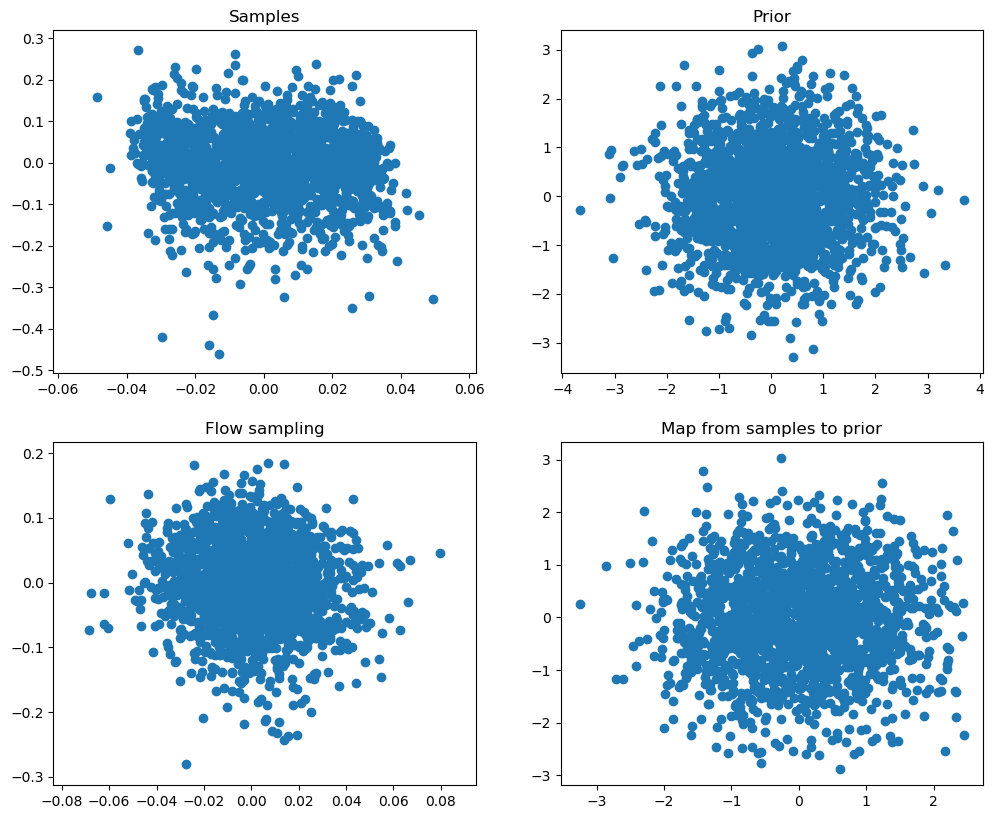

computing Arc model...
{'nll': 0.13439612211783727, 'loss': 0.13439612211783727, 'accuracy': 96.55333333333333}
{'nll': 0.14709076714515687, 'loss': 0.14709076714515687, 'accuracy': 95.91}
computing Sampling from flow model...
{'nll': 0.2902247237364451, 'loss': 0.2902247237364451, 'accuracy': 92.51}
{'nll': 0.30390853652954103, 'loss': 0.30390853652954103, 'accuracy': 91.65}
epoch 11: loss = -2200.027 time = 6.48
epoch 12: loss = -2202.839 time = 6.49
epoch 13: loss = -2205.904 time = 6.50
epoch 14: loss = -2209.012 time = 6.50
epoch 15: loss = -2211.926 time = 6.50
epoch 16: loss = -2215.532 time = 6.51
epoch 17: loss = -2218.386 time = 6.52
epoch 18: loss = -2221.629 time = 6.52
epoch 19: loss = -2224.508 time = 6.51
epoch 20: loss = -2228.237 time = 6.52
  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
  20     0.2806    92.8633     0.2970    92.4400    64.0484
copmuting samples...
drawing...


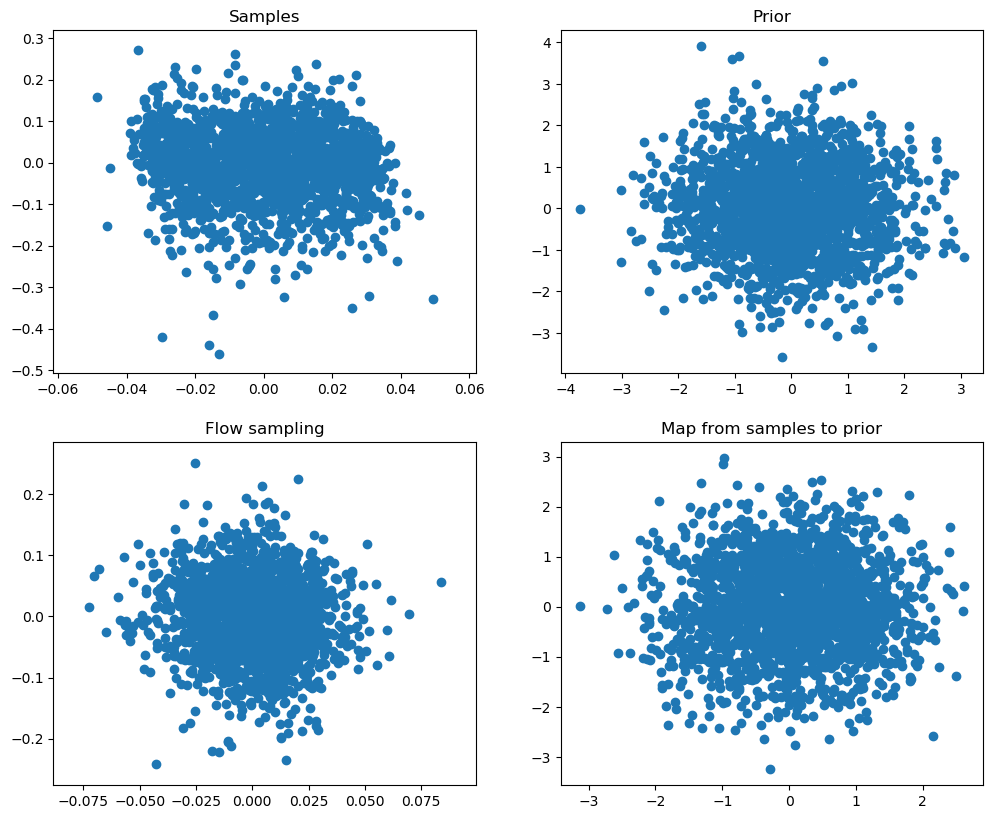

computing Arc model...
{'nll': 0.13775105801820756, 'loss': 0.13775105801820756, 'accuracy': 96.5}
{'nll': 0.1509302363872528, 'loss': 0.1509302363872528, 'accuracy': 95.83}
computing Sampling from flow model...
{'nll': 0.29210504587491354, 'loss': 0.29210504587491354, 'accuracy': 92.445}
{'nll': 0.2922306661128998, 'loss': 0.2922306661128998, 'accuracy': 92.39}
epoch 21: loss = -2235.303 time = 6.51
epoch 22: loss = -2239.930 time = 6.50
epoch 23: loss = -2243.076 time = 6.51
epoch 24: loss = -2245.595 time = 6.52
epoch 25: loss = -2249.040 time = 6.52
epoch 26: loss = -2252.227 time = 6.53
epoch 27: loss = -2255.521 time = 6.53
epoch 28: loss = -2258.786 time = 6.52
epoch 29: loss = -2262.375 time = 6.53
epoch 30: loss = -2265.479 time = 6.54
  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
  30     0.2788    92.4600     0.2912    91.8200    64.1462
copmuting samples...
drawing...


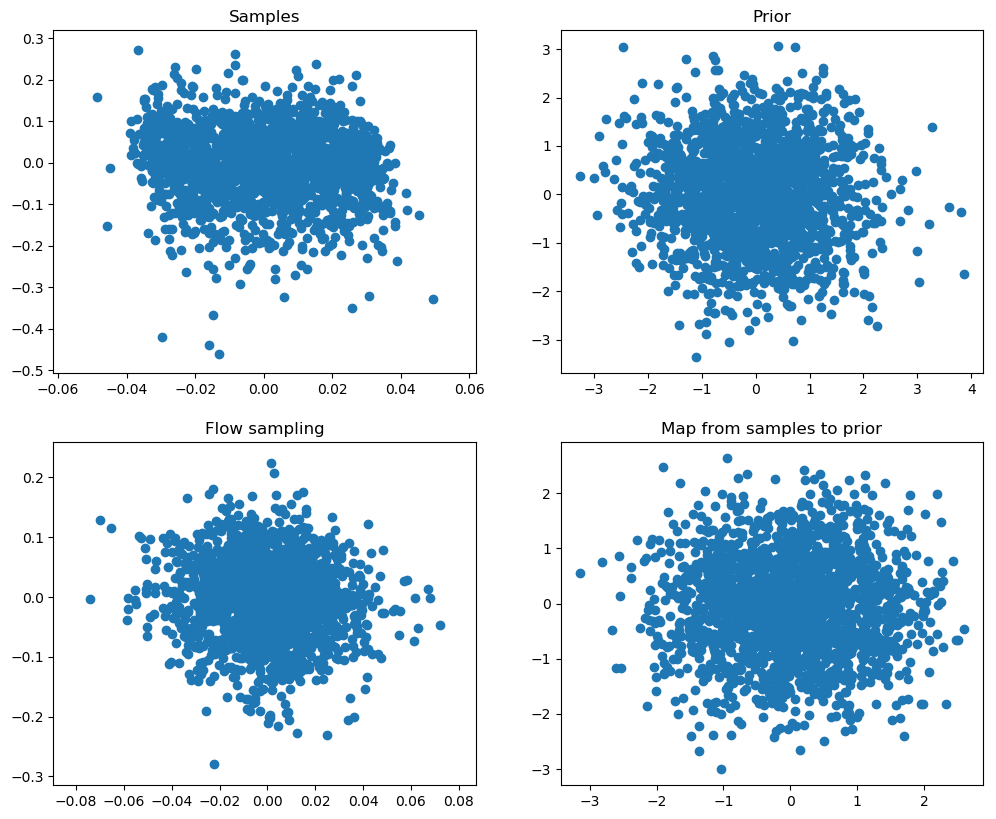

computing Arc model...
{'nll': 0.14234773949782054, 'loss': 0.14234773949782054, 'accuracy': 96.34833333333333}
{'nll': 0.15546848015785217, 'loss': 0.15546848015785217, 'accuracy': 95.73}
computing Sampling from flow model...
{'nll': 0.2819149836063385, 'loss': 0.2819149836063385, 'accuracy': 92.45166666666667}
{'nll': 0.2826317735671997, 'loss': 0.2826317735671997, 'accuracy': 92.49}
epoch 31: loss = -2268.978 time = 6.51
epoch 32: loss = -2272.192 time = 6.52
epoch 33: loss = -2275.771 time = 6.52
epoch 34: loss = -2278.960 time = 6.51
epoch 35: loss = -2281.923 time = 6.52
epoch 36: loss = -2285.712 time = 6.54
epoch 37: loss = -2289.275 time = 6.54
epoch 38: loss = -2292.627 time = 6.54
epoch 39: loss = -2296.289 time = 6.54
epoch 40: loss = -2299.417 time = 6.54
  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
  40     0.2736    92.5267     0.2827    91.8400    64.1779
copmuting samples...
drawing...


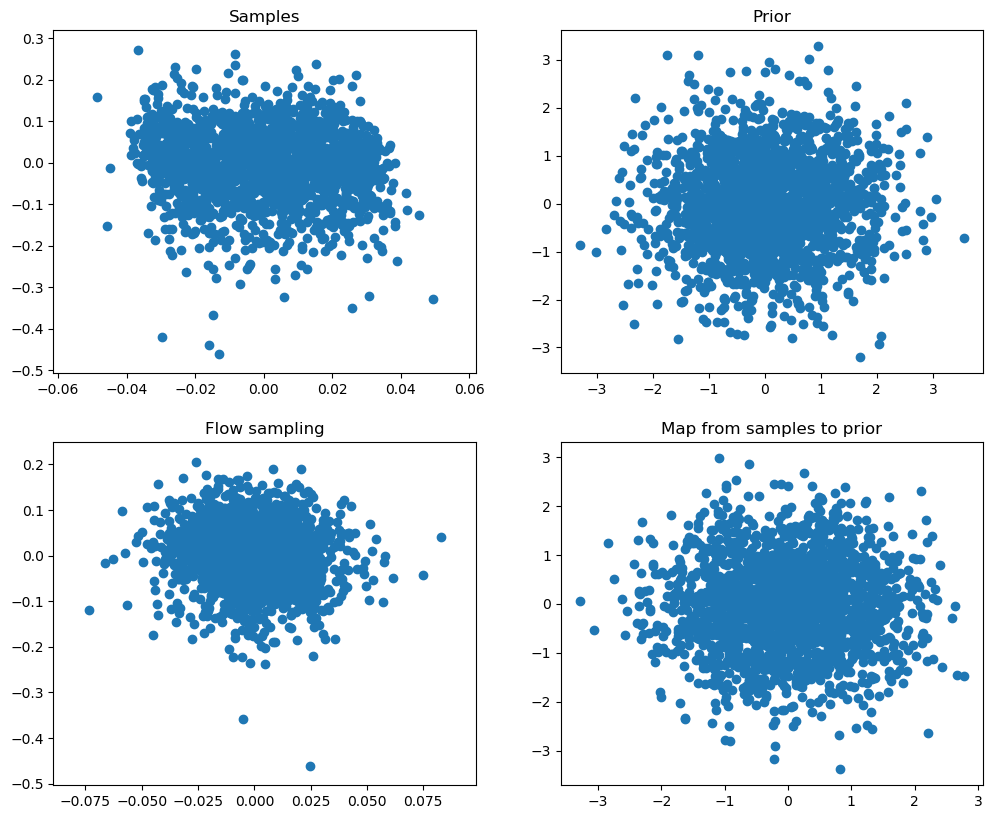

computing Arc model...
{'nll': 0.13400601561864217, 'loss': 0.13400601561864217, 'accuracy': 96.695}
{'nll': 0.14606355562210083, 'loss': 0.14606355562210083, 'accuracy': 96.0}
computing Sampling from flow model...
{'nll': 0.2723376768350601, 'loss': 0.2723376768350601, 'accuracy': 92.63666666666667}
{'nll': 0.26689348278045655, 'loss': 0.26689348278045655, 'accuracy': 92.89}
epoch 41: loss = -2307.997 time = 6.52
epoch 42: loss = -2312.702 time = 6.52
epoch 43: loss = -2315.686 time = 6.53
epoch 44: loss = -2319.280 time = 6.52
epoch 45: loss = -2322.681 time = 6.54
epoch 46: loss = -2326.284 time = 6.53
epoch 47: loss = -2328.687 time = 6.53
epoch 48: loss = -2332.555 time = 6.54
epoch 49: loss = -2335.486 time = 6.53
epoch 50: loss = -2338.625 time = 6.54
  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
  50     0.2681    92.8183     0.2836    92.2200    64.1889
copmuting samples...
drawing...


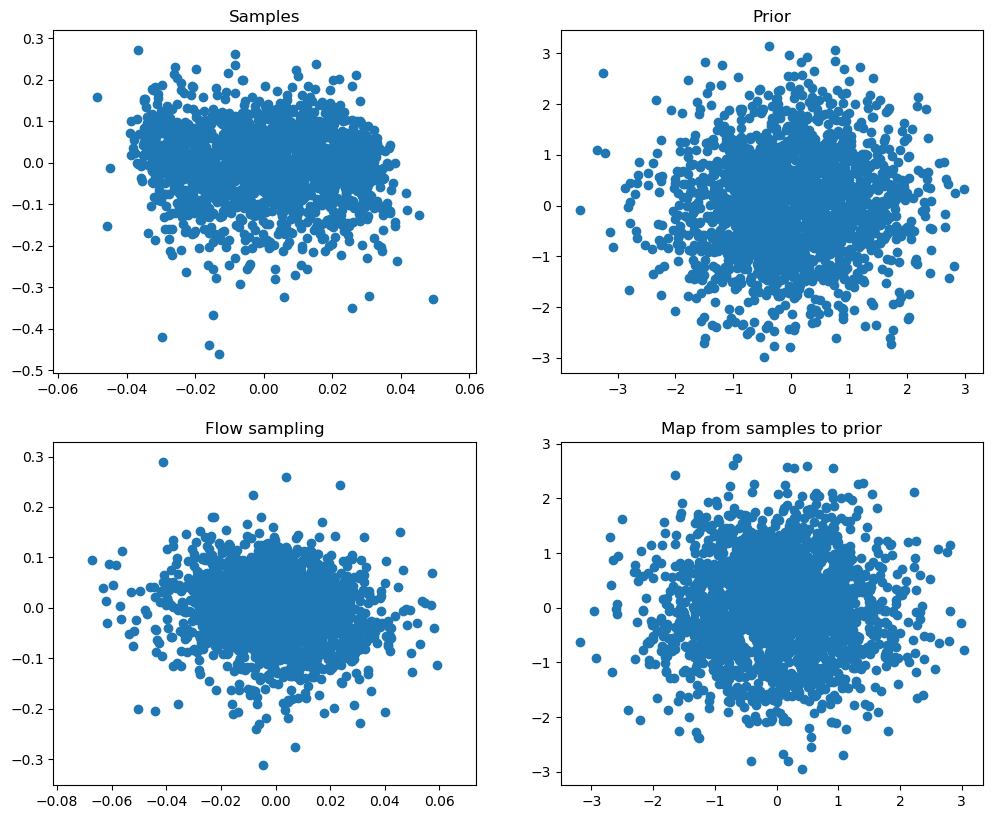

computing Arc model...
{'nll': 0.1370548046350479, 'loss': 0.1370548046350479, 'accuracy': 96.53333333333333}
{'nll': 0.14703723363876342, 'loss': 0.14703723363876342, 'accuracy': 96.12}
computing Sampling from flow model...
{'nll': 0.2653236526012421, 'loss': 0.2653236526012421, 'accuracy': 92.68}
{'nll': 0.27282474813461305, 'loss': 0.27282474813461305, 'accuracy': 92.32}
epoch 51: loss = -2342.389 time = 6.52
epoch 52: loss = -2345.623 time = 6.53
epoch 53: loss = -2348.675 time = 6.53
epoch 54: loss = -2352.206 time = 6.53
epoch 55: loss = -2354.795 time = 6.53
epoch 56: loss = -2358.888 time = 6.54
epoch 57: loss = -2362.201 time = 6.53
epoch 58: loss = -2364.942 time = 6.54
epoch 59: loss = -2367.304 time = 6.55
epoch 60: loss = -2370.771 time = 6.55
  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
  60     0.2613    93.1800     0.2705    92.9100    64.2646
copmuting samples...
drawing...


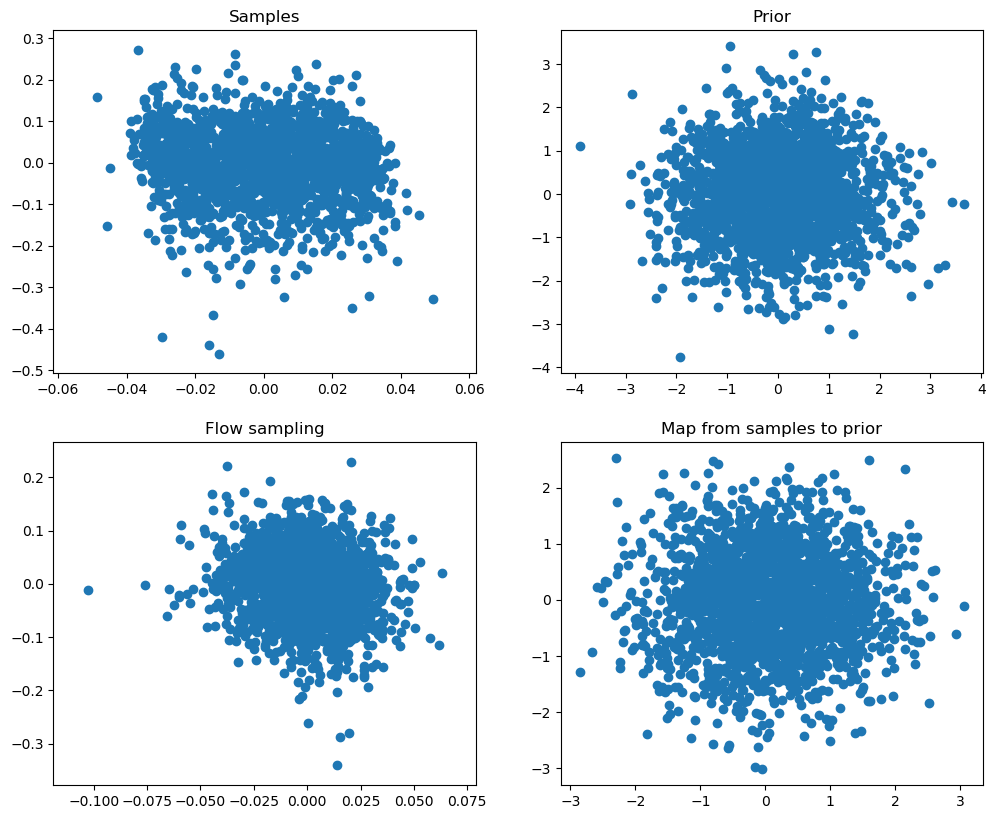

computing Arc model...
{'nll': 0.14155299307107924, 'loss': 0.14155299307107924, 'accuracy': 96.515}
{'nll': 0.15418776330947875, 'loss': 0.15418776330947875, 'accuracy': 95.87}
computing Sampling from flow model...
{'nll': 0.2673092923641205, 'loss': 0.2673092923641205, 'accuracy': 92.93833333333333}
{'nll': 0.27210830855369567, 'loss': 0.27210830855369567, 'accuracy': 92.59}
epoch 61: loss = -2380.373 time = 6.52
epoch 62: loss = -2384.934 time = 6.52
epoch 63: loss = -2387.753 time = 6.55
epoch 64: loss = -2390.449 time = 6.54
epoch 65: loss = -2392.939 time = 6.54
epoch 66: loss = -2395.247 time = 6.55
epoch 67: loss = -2398.836 time = 6.54
epoch 68: loss = -2401.864 time = 6.54
epoch 69: loss = -2404.820 time = 6.55
epoch 70: loss = -2407.852 time = 6.54


In [ ]:
train(flow, model1, model2, epochs=1000, lr=1e-4, batchsize=1024, step=1, test_every=10)

copmuting samples...
drawing...


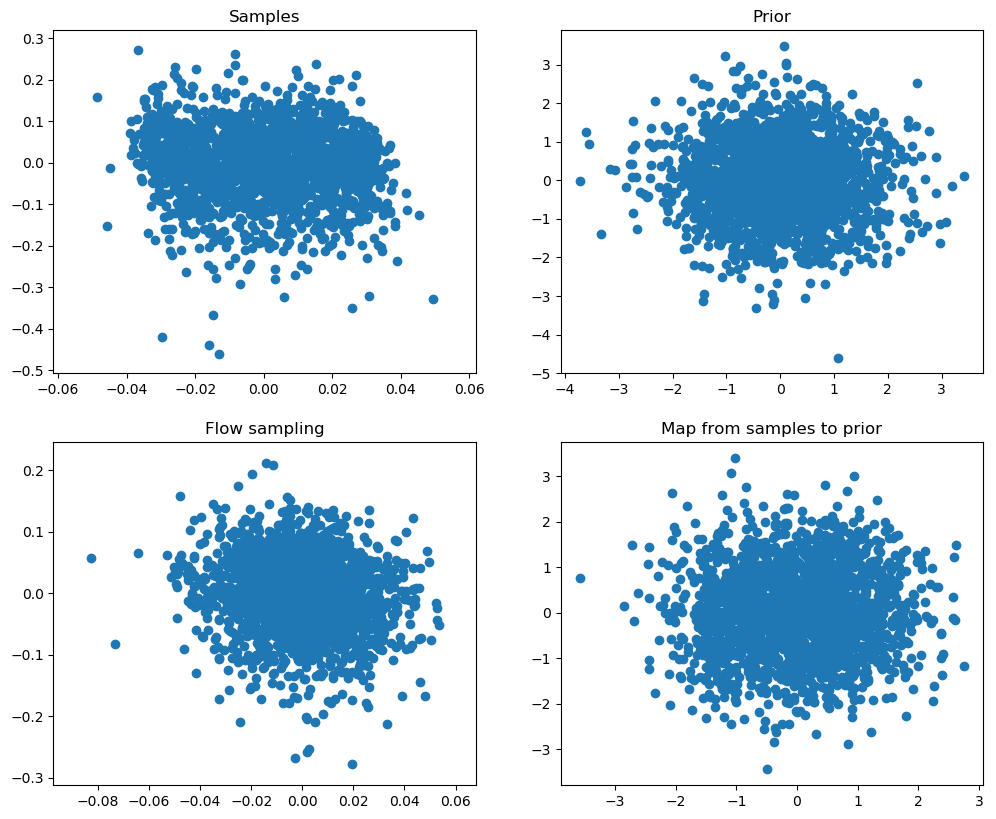

computing Arc model...
{'nll': 0.13043032089074452, 'loss': 0.13043032089074452, 'accuracy': 96.87666666666667}
{'nll': 0.1432998501777649, 'loss': 0.1432998501777649, 'accuracy': 96.15}
computing Sampling from flow model...
{'nll': 0.3703937327861786, 'loss': 0.3703937327861786, 'accuracy': 89.045}
{'nll': 0.3779758233547211, 'loss': 0.3779758233547211, 'accuracy': 88.86}


In [33]:
test_flow(S, model1, model2, flow, N=2000)